# Statistical bigram model


In [68]:
words = open(r'data\names.txt','r').read().splitlines()
len(words)

32033

In [69]:
def get_bigram_pairs(word : str) -> list[tuple[str,str]]:
    chars = ['.'] + list(word) + ['.']
    pairs = [(i,j) for i,j in zip(chars,chars[1:])]
    return pairs

In [70]:

# make bigram stat
bigram_stat = {}
for word in words:
    pairs = get_bigram_pairs(word)
    for pair in pairs:
        bigram_stat[pair] = bigram_stat.get(pair,0) + 1


In [71]:
# make char -> index lookup table
chars = sorted(list(set(''.join(words))))
chars = ['.'] + chars

char2idx = {c:i for i,c in enumerate(chars)}


In [72]:
import torch

# make bigram stat tensor
bigram_stat_tensor = torch.zeros((28,28),dtype=torch.int32)

for word in words:
    pairs = get_bigram_pairs(word)
    for pair in pairs:
        i,j = char2idx[pair[0]],char2idx[pair[1]]
        bigram_stat_tensor[i,j] += 1

(-0.5, 27.5, 27.5, -0.5)

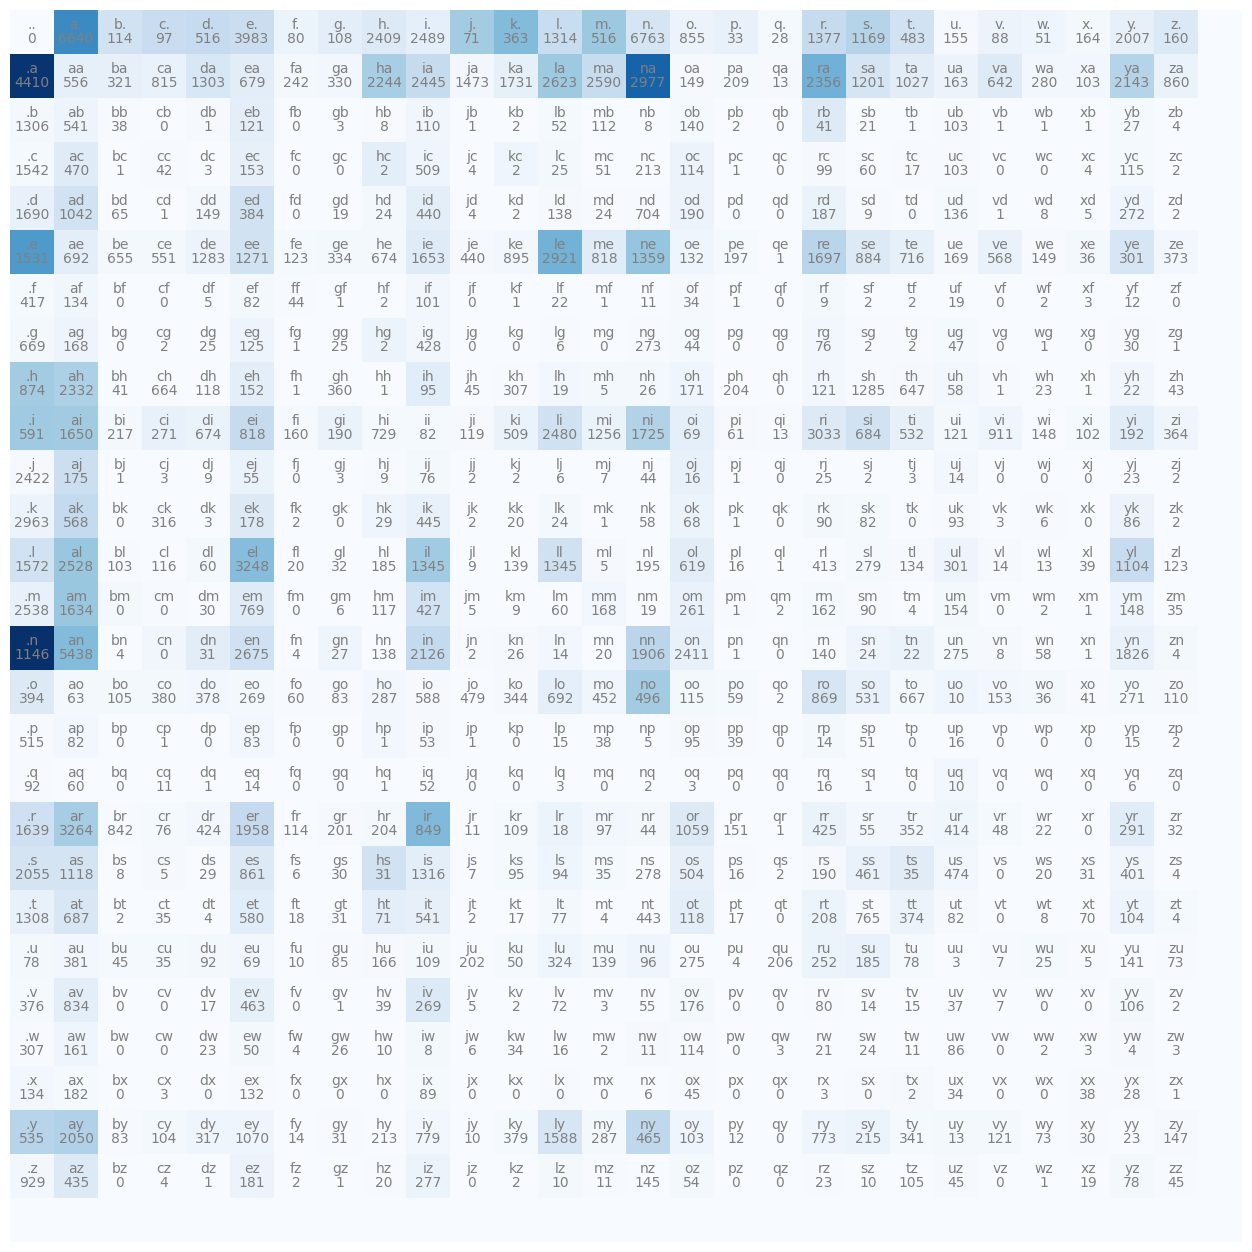

In [73]:
import matplotlib.pyplot as plt
%matplotlib inline

# visualize bigram stat
idx2char = {i:c for c,i in char2idx.items()}
plt.figure(figsize=(16,16))
plt.imshow(bigram_stat_tensor, cmap='Blues')

for i in range(27):
    for j in range(27):
        cell_name = idx2char[i]+idx2char[j]

        plt.text(i,j,cell_name,ha='center',va='bottom', color="gray")
        plt.text(i,j, bigram_stat_tensor[i,j].item(),ha='center',va='top',color="gray")

plt.axis('off')


In [74]:
# calculate bigram probablity distribution
# What this distrubution means is that, given a char, what is the probablity of the next char
bigram_prob_dist = (bigram_stat_tensor+1).float() # adding 1 to smooth the distribution

# This is normalization. Meaning, we want to make sure that the sum of each row is 1
bigram_prob_dist = bigram_prob_dist / bigram_prob_dist.sum(dim=1,keepdim=True) 

# How to you know  bigram_prob_dist / bigram_prob_dist.sum(dim=1,keepdim=True) operation is dobable?
# Broadcasting rules: 
# https://pytorch.org/docs/stable/notes/broadcasting.html
# 27,27
# 27,1 -> 27,27, is doable

In [75]:
# bigram language model generator
rand_gen = torch.Generator().manual_seed(2147483647)

def generate_words() -> str:
    out = []
    current_row = 0
    while True:
        probability_dist = bigram_prob_dist[current_row]
        next_row = torch.multinomial(probability_dist,1,generator=rand_gen, replacement=True).item()
        if next_row == 0:
            break

        out.append(idx2char[next_row])
        current_row = next_row

    return ''.join(out)


for _ in range(5):
    print(generate_words())


    

mor
axx
minaymoryles
kondlaisah
anchthizarie


In [76]:
# compute -ve log likelyhood probablity of a word

total_log_prob = 0
n = 0
for w in words:
    pairs = get_bigram_pairs(w)
    for pair in pairs:
        i,j = char2idx[pair[0]],char2idx[pair[1]]
        log_prob = torch.log(bigram_prob_dist[i,j])
        total_log_prob += log_prob
        n += 1
        # print(f"{pair[0]},{pair[1]}:{log_prob.item()}")

print(f"total log probablity:{total_log_prob.item()}")
print(f"average -ve log probablity:{-total_log_prob.item()/n}")


total log probablity:-559978.75
average -ve log probablity:2.4544754236322355


# Neural network based bigram model



In [328]:
# Create the training set
import torch.nn.functional as F

xs, ys = [], []

for w in words:
    pairs = get_bigram_pairs(w)
    for pair in pairs:
        i,j = char2idx[pair[0]],char2idx[pair[1]]
        xs.append(i)
        ys.append(j)

xs = torch.tensor(xs)
x_enc = F.one_hot(xs, num_classes=27).float()

ys = torch.tensor(ys)
total_bigram = len(xs)
total_bigram


228146

In [329]:
rand_gen = torch.Generator().manual_seed(2147483647)

# initialize weights
weights = torch.randn((27,27), generator=rand_gen, requires_grad=True)


In [ ]:
# training loop
for k in range(1000):
    # Forward pass
    # The following 2 lines is the same as softmax
    logits = x_enc @ weights # log of counts
    count = logits.exp() # counts
    probs = count / count.sum(dim=1,keepdim=True) # normalised probablity distribution

    # compute -ve log likelyhood probablity of a word
    # # index into probs with (batch_size, index) to get the probability of the correct character
    # probs[0,index_of_1st_bigram] + probs[1,index_of_2nd_bigram] + probs[2,index_of_3rd_bigram]  = probs[torch.arange(3),ys]
    loss = -probs[torch.arange(total_bigram),ys].log().mean()

    # Regularization
    # 0.01 is the regularization strength
    # Regularization adds a force to the weights to be small, by introducing a positive term to the loss function
    loss = loss + 0.01 * weights.pow(2).mean()

    print(f"{k}:{loss.item()}")


    # backward pass
    weights.grad = None
    loss.backward(retain_graph=True)

    # update weights
    weights.data += -10 * weights.grad


In [334]:
# Inference

rand_gen = torch.Generator().manual_seed(2147483647)

# generate words
for _ in range(5):
    out = []   
    ix = 0
    while True:
        x_enc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
        logits = x_enc @ weights
        count = logits.exp()
        probs = count / count.sum(dim=1,keepdim=True)
        
        next_ix = torch.multinomial(probs,1,generator=rand_gen, replacement=True).item()


        if next_ix == 0:
            break

        out.append(idx2char[next_ix])
        ix = next_ix

    print(''.join(out))
    

mor
axx
minaymoryles
kondmaisah
anchshizarie
